# Talent Hunting Classification with Machine Learning using SCOUTIUM's Dataset

In [1]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV
from tabulate import tabulate

# Settings
warnings.simplefilter(action='ignore', category=Warning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


# Tasks

Step 1: Read the 'scoutium_attributes.csv' and 'scoutium_potential_labels.csv' files.

In [2]:
df_attribute = pd.read_csv('scoutium_attributes.csv', sep=';')
df_attribute.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value
0,4915,62935,177676,1361061,2,12818495,4322,56.000
1,4915,62935,177676,1361061,2,12818495,4323,56.000
2,4915,62935,177676,1361061,2,12818495,4324,67.000
3,4915,62935,177676,1361061,2,12818495,4325,56.000
4,4915,62935,177676,1361061,2,12818495,4326,45.000


In [3]:
df_label = pd.read_csv('scoutium_potential_labels.csv', sep=';')
df_label.head()

,task_response_id,match_id,evaluator_id,player_id,potential_label
0,4915,62935,177676,1361061,average
1,4915,62935,177676,1361626,highlighted
2,4915,62935,177676,1361858,average
3,4915,62935,177676,1362220,highlighted
4,4915,62935,177676,1364951,highlighted


Step 2: Combine the csv files we have read using the merge() function ('task_response_id', 'match_id', 'evaluator_id', 'player_id' perform the merge() operation over 4 variables).

In [4]:
df = pd.merge(df_attribute, df_label, how='left', on=['task_response_id', 'match_id', 'evaluator_id', 'player_id'])

In [5]:
df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.000,average
1,4915,62935,177676,1361061,2,12818495,4323,56.000,average
2,4915,62935,177676,1361061,2,12818495,4324,67.000,average
3,4915,62935,177676,1361061,2,12818495,4325,56.000,average
4,4915,62935,177676,1361061,2,12818495,4326,45.000,average


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10730 entries, 0 to 10729
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   task_response_id  10730 non-null  int64  
 1   match_id          10730 non-null  int64  
 2   evaluator_id      10730 non-null  int64  
 3   player_id         10730 non-null  int64  
 4   position_id       10730 non-null  int64  
 5   analysis_id       10730 non-null  int64  
 6   attribute_id      10730 non-null  int64  
 7   attribute_value   10730 non-null  float64
 8   potential_label   10730 non-null  object 
dtypes: float64(1), int64(7), object(1)
memory usage: 838.3+ KB


Step 3: Remove the 'Keeper (1)' class in 'position_id' from the dataset.

In [7]:
df.drop(df[df['position_id'] == 1].index, inplace=True)

Step 4: Remove the 'below_average' class in the 'potential_label' from the dataset (The 'below_average' class makes up 1% of the entire dataset).

In [8]:
df['potential_label'].value_counts()

average          7922
highlighted      1972
below_average     136
Name: potential_label, dtype: int64

In [9]:
df.drop(df[df['potential_label'] == 'below_average'].index, inplace=True)

Step 5: Create a table from the dataset you created using the pivot_table() function. Manipulate this pivot table with one player per row.
- Create the pivot table with 'player_id', 'position_id' and 'potential_label' in the index, 'attribute_id' in the columns and 'attribute_value' in the values given by the scouts to the players.
- Assign the indexes as variables using the reset_index() function and convert the names of the 'attribute_id' columns to strings.

In [10]:
# Pivot table
df = pd.pivot_table(data=df, values='attribute_value', index=['player_id', 'position_id', 'potential_label'], columns='attribute_id')
df.head()

attribute_id                            4322   4323   4324   4325   4326   4327   4328   4329   4330   4332   4333   4335   4338   4339   4340   4341   4342   4343   4344   4345   4348   4349   4350   4351   4352   4353   4354   4355   4356   4357   4407   4408   4423   4426
player_id position_id potential_label                                                                                                                                                                                                                                              
1355710   7           average         50.500 50.500 34.000 50.500 45.000 45.000 45.000 45.000 50.500 56.000 39.500 34.000 39.500 39.500 45.000 45.000 50.500 28.500 23.000 39.500 28.500 28.500 45.000 50.500 56.000 34.000 39.500 50.500 34.000 34.000 56.000 34.000 34.000 56.000
1356362   9           average         67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 56.000 67.000 67.000 56.000 67.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000 67.000 67.000 56.000 78.000
1356375   3           average         67.000 67.000 67.000 67.000 67.000 67.000 67.000 78.000 67.000 67.000 78.000 56.000 67.000 67.000 67.000 67.000 67.000 56.000 56.000 67.000 67.000 56.000 56.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000 67.000 67.000 56.000 78.000
          4           average         67.000 78.000 67.000 67.000 67.000 78.000 78.000 78.000 56.000 67.000 67.000 67.000 78.000 78.000 56.000 67.000 67.000 45.000 45.000 56.000 67.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000 56.000 67.000 56.000 67.000 45.000 56.000
1356411   9           average         67.000 67.000 78.000 78.000 67.000 67.000 67.000 67.000 89.000 78.000 67.000 67.000 67.000 56.000 56.000 67.000 78.000 56.000 56.000 67.000 56.000 67.000 56.000 67.000 67.000 56.000 67.000 67.000 56.000 67.000 89.000 56.000 67.000 78.000

In [11]:
# Reset index
df.reset_index(inplace=True)
df.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,average,50.500,50.500,34.000,50.500,45.000,45.000,45.000,45.000,50.500,56.000,39.500,34.000,39.500,39.500,45.000,45.000,50.500,28.500,23.000,39.500,28.500,28.500,45.000,50.500,56.000,34.000,39.500,50.500,34.000,34.000,56.000,34.000,34.000,56.000
1,1356362,9,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
2,1356375,3,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,78.000,56.000,67.000,67.000,67.000,67.000,67.000,56.000,56.000,67.000,67.000,56.000,56.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
3,1356375,4,average,67.000,78.000,67.000,67.000,67.000,78.000,78.000,78.000,56.000,67.000,67.000,67.000,78.000,78.000,56.000,67.000,67.000,45.000,45.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,56.000,67.000,56.000,67.000,45.000,56.000
4,1356411,9,average,67.000,67.000,78.000,78.000,67.000,67.000,67.000,67.000,89.000,78.000,67.000,67.000,67.000,56.000,56.000,67.000,78.000,56.000,56.000,67.000,56.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,89.000,56.000,67.000,78.000


In [12]:
# Converting the names of the 'attribute_id' columns to strings
df.columns = df.columns.map(str)
df.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,average,50.500,50.500,34.000,50.500,45.000,45.000,45.000,45.000,50.500,56.000,39.500,34.000,39.500,39.500,45.000,45.000,50.500,28.500,23.000,39.500,28.500,28.500,45.000,50.500,56.000,34.000,39.500,50.500,34.000,34.000,56.000,34.000,34.000,56.000
1,1356362,9,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
2,1356375,3,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,78.000,56.000,67.000,67.000,67.000,67.000,67.000,56.000,56.000,67.000,67.000,56.000,56.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
3,1356375,4,average,67.000,78.000,67.000,67.000,67.000,78.000,78.000,78.000,56.000,67.000,67.000,67.000,78.000,78.000,56.000,67.000,67.000,45.000,45.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,56.000,67.000,56.000,67.000,45.000,56.000
4,1356411,9,average,67.000,67.000,78.000,78.000,67.000,67.000,67.000,67.000,89.000,78.000,67.000,67.000,67.000,56.000,56.000,67.000,78.000,56.000,56.000,67.000,56.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,89.000,56.000,67.000,78.000


Step 6: Express the 'potential_label' categories (average, highlighted) numerically using the LabelEncoder() function.

In [13]:
df['potential_label'].unique()

array(['average', 'highlighted'], dtype=object)

In [14]:
le = LabelEncoder()
df['potential_label'] = le.fit_transform(df['potential_label'])
df.tail()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
266,1907347,5,0,67.000,78.000,78.000,56.000,78.000,67.000,78.000,67.000,56.000,78.000,78.000,56.000,67.000,67.000,78.000,56.000,67.000,56.000,56.000,67.000,78.000,89.000,67.000,78.000,67.000,67.000,67.000,67.000,56.000,67.000,78.000,78.000,78.000,56.000
267,1907347,6,0,67.000,67.000,67.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,78.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,56.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,67.000,78.000
268,1909532,10,0,56.000,45.000,45.000,45.000,56.000,56.000,56.000,56.000,23.000,23.000,34.000,45.000,56.000,34.000,23.000,45.000,45.000,23.000,23.000,34.000,23.000,23.000,34.000,23.000,45.000,45.000,56.000,34.000,34.000,56.000,34.000,34.000,34.000,23.000
269,1909724,2,1,78.000,78.000,78.000,78.000,78.000,78.000,78.000,78.000,67.000,67.000,78.000,78.000,78.000,67.000,78.000,67.000,78.000,56.000,56.000,78.000,78.000,67.000,78.000,78.000,78.000,78.000,78.000,67.000,67.000,67.000,78.000,78.000,67.000,78.000
270,1909728,7,1,78.000,67.000,67.000,78.000,67.000,67.000,67.000,78.000,67.000,67.000,78.000,67.000,78.000,67.000,67.000,78.000,78.000,67.000,56.000,78.000,67.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,78.000,67.000,67.000,78.000


Step 7: Assign the numeric variable columns to a list with the name 'num_cols'.

In [15]:
# 'player_id', 'position_id', 'potential_label' are not numerical variables
num_cols = [col for col in df.columns if col not in ['player_id', 'position_id', 'potential_label']] # df.columns[3:]
num_cols[:5]

['4322', '4323', '4324', '4325', '4326']

Step 8: Apply StandardScaler() to scale the data in all the 'num_cols' variables you have saved.

In [16]:
s_scaler = StandardScaler()
df[num_cols] = s_scaler.fit_transform(df[num_cols])
df.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,-0.543,-0.559,-1.405,-0.438,-0.767,-0.795,-0.907,-0.792,-0.446,-0.123,-1.224,-1.036,-1.126,-1.009,-0.542,-0.690,-0.535,-1.067,-1.206,-1.005,-1.314,-1.042,-0.693,-0.436,0.013,-1.282,-1.132,-0.495,-1.235,-1.520,-0.143,-1.487,-0.955,-0.253
1,1356362,9,0,0.595,0.561,0.679,0.683,0.723,0.723,0.601,0.404,0.728,0.691,0.459,0.996,0.632,0.840,0.912,0.799,0.588,1.230,0.750,0.742,0.879,0.670,0.848,0.717,0.787,0.814,1.053,0.632,0.915,0.768,0.530,0.669,0.404,1.042
2,1356375,3,0,0.595,0.561,0.679,0.683,0.723,0.723,0.601,1.002,0.728,0.691,1.132,0.319,0.632,0.840,0.912,0.799,0.588,0.574,0.750,0.742,0.879,0.670,0.077,0.717,0.787,0.814,1.053,0.632,0.915,0.768,0.530,0.669,0.404,1.042
3,1356375,4,0,0.595,1.308,0.679,0.683,0.723,1.482,1.355,1.002,-0.055,0.691,0.459,0.996,1.335,1.580,0.185,0.799,0.588,-0.083,0.098,0.043,0.879,1.355,0.848,0.717,1.560,0.814,0.428,0.632,0.198,0.768,-0.143,0.669,-0.276,-0.253
4,1356411,9,0,0.595,0.561,1.373,1.430,0.723,0.723,0.601,0.404,2.294,1.505,0.459,0.996,0.632,0.101,0.185,0.799,1.337,0.574,0.750,0.742,0.252,1.355,0.077,0.717,0.787,0.115,0.428,0.632,0.198,0.768,1.874,-0.050,1.083,1.042


Step 9: Develop a machine learning model that predicts the potential tags of football players with minimum error from the dataset we have (Print the roc_auc, f1, precision, recall, accuracy metrics).

In [17]:
df.shape

(271, 37)

In [18]:
y = df['potential_label']
X = df.drop(['player_id', 'potential_label'], axis=1)

### Base Model

In [19]:
def base_models(X, y, scoring='accuracy'):
    print('Base Models...')
    models = [('LR', LogisticRegression(random_state=42)), 
              ('KNN', KNeighborsClassifier()), 
              ('CART', DecisionTreeClassifier(random_state=42)),
              ('RF', RandomForestClassifier(random_state=42)),
              ('SVC', SVC(random_state=42)),
              ('Adaboost', AdaBoostClassifier(random_state=42)),
              ('GBM', GradientBoostingClassifier(random_state=42)),
              ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
              ('LightGBM', LGBMClassifier(random_state=42)),
              ('CatBoost', CatBoostClassifier(verbose=False, random_state=42))
              ]

    scoring = [scoring] if isinstance(scoring, str) else scoring

    for score in scoring:
        print(f'{score}:')
        for name, model in models:
            cv_results = cross_validate(model, X, y, cv=5, scoring=score)
            print(f"\t{cv_results['test_score'].mean():.3f} ({name})")
        print()


base_models(X, y, scoring=['accuracy', 'roc_auc', 'f1', 'recall', 'precision'])

Base Models...
accuracy:
	0.845 (LR)
	0.838 (KNN)
	0.794 (CART)
	0.878 (RF)
	0.801 (SVC)
	0.856 (Adaboost)
	0.875 (GBM)
	0.856 (XGBoost)
	0.871 (LightGBM)
	0.871 (CatBoost)

roc_auc:
	0.833 (LR)
	0.746 (KNN)
	0.723 (CART)
	0.907 (RF)
	0.838 (SVC)
	0.847 (Adaboost)
	0.881 (GBM)
	0.854 (XGBoost)
	0.883 (LightGBM)
	0.892 (CatBoost)

f1:
	0.555 (LR)
	0.383 (KNN)
	0.554 (CART)
	0.580 (RF)
	0.067 (SVC)
	0.622 (Adaboost)
	0.638 (GBM)
	0.608 (XGBoost)
	0.648 (LightGBM)
	0.585 (CatBoost)

recall:
	0.482 (LR)
	0.264 (KNN)
	0.605 (CART)
	0.442 (RF)
	0.036 (SVC)
	0.585 (Adaboost)
	0.550 (GBM)
	0.550 (XGBoost)
	0.586 (LightGBM)
	0.461 (CatBoost)

precision:
	0.683 (LR)
	0.855 (KNN)
	0.534 (CART)
	0.960 (RF)
	0.400 (SVC)
	0.711 (Adaboost)
	0.798 (GBM)
	0.733 (XGBoost)
	0.770 (LightGBM)
	0.893 (CatBoost)



### Hyperparameter Optimization for Selected Models

- Random Forest

In [20]:
rf_model = RandomForestClassifier(random_state=42)

In [21]:
rf_model.get_params() 

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [22]:
rf_params = {'max_depth': [5, 8, 10, None],
             'max_features': [3, 5, 7, 'auto'],
             'min_samples_split': [2, 5, 10, 15, 20],
             'n_estimators': [100, 200, 400, 500]}

In [23]:
grid_search = GridSearchCV(rf_model, 
                           rf_params, 
                           cv=5, 
                           n_jobs=-1, 
                           verbose=True).fit(X, y)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


In [24]:
grid_search.best_params_

{'max_depth': 10,
 'max_features': 5,
 'min_samples_split': 5,
 'n_estimators': 100}

In [25]:
grid_search.best_score_

0.8855892255892256

In [26]:
rf_tuned = rf_model.set_params(**grid_search.best_params_, random_state=42)
rf_tuned.fit(X, y)

RandomForestClassifier(max_depth=10, max_features=5, min_samples_split=5,
                       random_state=42)

In [27]:
# Cross-Validation with Tuned Random Forest
scoring = ['accuracy', 'roc_auc', 'f1', 'recall', 'precision']

cv_results = cross_validate(rf_tuned, X, y, cv=5, scoring=scoring)

for score in scoring:
    mean_score = np.mean(cv_results[f'test_{score}'])
    print(f'{score}: {mean_score:.3f}')

accuracy: 0.886
roc_auc: 0.916
f1: 0.622
recall: 0.479
precision: 0.960


- LightGBM

In [28]:
lgbm_model = LGBMClassifier(random_state=42)

In [29]:
lgbm_params = {'learning_rate': [0.01, 0.1, 0.001],
               'n_estimators': [100, 300, 500, 700, 1000],
               'colsample_bytree': [0.5, 0.7, 1]}

In [30]:
grid_search = GridSearchCV(lgbm_model, 
                              lgbm_params, 
                              cv=5, 
                              n_jobs=-1, 
                              verbose=True).fit(X, y)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


In [31]:
grid_search.best_params_

{'colsample_bytree': 1, 'learning_rate': 0.01, 'n_estimators': 300}

In [32]:
grid_search.best_score_

0.8856565656565657

In [33]:
lgbm_tuned = lgbm_model.set_params(**grid_search.best_params_, random_state=42)
lgbm_tuned.fit(X, y)

LGBMClassifier(colsample_bytree=1, learning_rate=0.01, n_estimators=300,
               random_state=42)

In [34]:
# Cross-Validation with Tuned LightGBM
scoring = ['accuracy', 'roc_auc', 'f1', 'recall', 'precision']

cv_results = cross_validate(lgbm_tuned, X, y, cv=5, scoring=scoring)

for score in scoring:
    mean_score = np.mean(cv_results[f'test_{score}'])
    print(f'{score}: {mean_score:.3f}')

accuracy: 0.886
roc_auc: 0.881
f1: 0.653
recall: 0.550
precision: 0.888


- Model Performance Metrics before and after Hyperparameter Optimization

In [35]:
# Results for Random Forest
rf_results = [
    ['RF Before Hyperparameter Opt.', 0.878, 0.907, 0.580, 0.442, 0.960],
    ['RF After Hyperparameter Opt.', 0.886, 0.916, 0.622, 0.479, 0.960]
]

# Results for LightGBM
lgbm_results = [
    ['LightGBM Before Hyperparameter Opt.', 0.871, 0.883, 0.648, 0.586, 0.770],
    ['LightGBM After Hyperparameter Opt.', 0.886, 0.881, 0.653, 0.550, 0.888]
]

# Column names
columns = ['', 'accuracy', 'roc_auc', 'f1', 'recall', 'precision']

# Table formatting for Random Forest
table_rf = tabulate(rf_results, headers=columns, tablefmt='simple_grid', floatfmt='.3f')

# Table formatting for LightGBM
table_lgbm = tabulate(lgbm_results, headers=columns, tablefmt='simple_grid', floatfmt='.3f')

print("\nResults for RF")
print(table_rf)

print("\nResults for LightGBM")
print(table_lgbm)



Results for RF
┌───────────────────────────────┬────────────┬───────────┬───────┬──────────┬─────────────┐
│                               │   accuracy │   roc_auc │    f1 │   recall │   precision │
├───────────────────────────────┼────────────┼───────────┼───────┼──────────┼─────────────┤
│ RF Before Hyperparameter Opt. │      0.878 │     0.907 │ 0.580 │    0.442 │       0.960 │
├───────────────────────────────┼────────────┼───────────┼───────┼──────────┼─────────────┤
│ RF After Hyperparameter Opt.  │      0.886 │     0.916 │ 0.622 │    0.479 │       0.960 │
└───────────────────────────────┴────────────┴───────────┴───────┴──────────┴─────────────┘

Results for LightGBM
┌─────────────────────────────────────┬────────────┬───────────┬───────┬──────────┬─────────────┐
│                                     │   accuracy │   roc_auc │    f1 │   recall │   precision │
├─────────────────────────────────────┼────────────┼───────────┼───────┼──────────┼─────────────┤
│ LightGBM Before Hyperp

- Prediction

In [36]:
random_user = X.sample(1, random_state=14)
prediction_rf = rf_tuned.predict(random_user)
prediction_lgbm = lgbm_tuned.predict(random_user)

print(f'Random Forest Prediction: {prediction_rf}')
print(f'LightGBM Prediction: {prediction_lgbm}')

Random Forest Prediction: [1]
LightGBM Prediction: [1]


Step 10: Draw the order of the features using the 'feature_importance' function, which indicates the importance of the variables.

In [37]:
# Feature importance
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values('Value',ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x='Value', y='Feature', data=feature_imp.sort_values(by='Value',
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

Feature Importance for Random Forest:
    Value      Feature
4   0.119         4325
5   0.079         4326
16  0.067         4341
19  0.049         4344
24  0.043         4351
20  0.039         4345
23  0.037         4350
26  0.036         4353
14  0.032         4339
31  0.030         4407
1   0.027         4322
18  0.026         4343
13  0.026         4338
21  0.025         4348
15  0.023         4340
25  0.022         4352
22  0.022         4349
7   0.022         4328
17  0.022         4342
12  0.021         4335
33  0.020         4423
30  0.020         4357
0   0.020  position_id
8   0.019         4329
34  0.017         4426
29  0.017         4356
3   0.016         4324
10  0.016         4332
6   0.015         4327
9   0.015         4330
11  0.014         4333
32  0.012         4408
27  0.012         4354
28  0.012         4355
2   0.010         4323


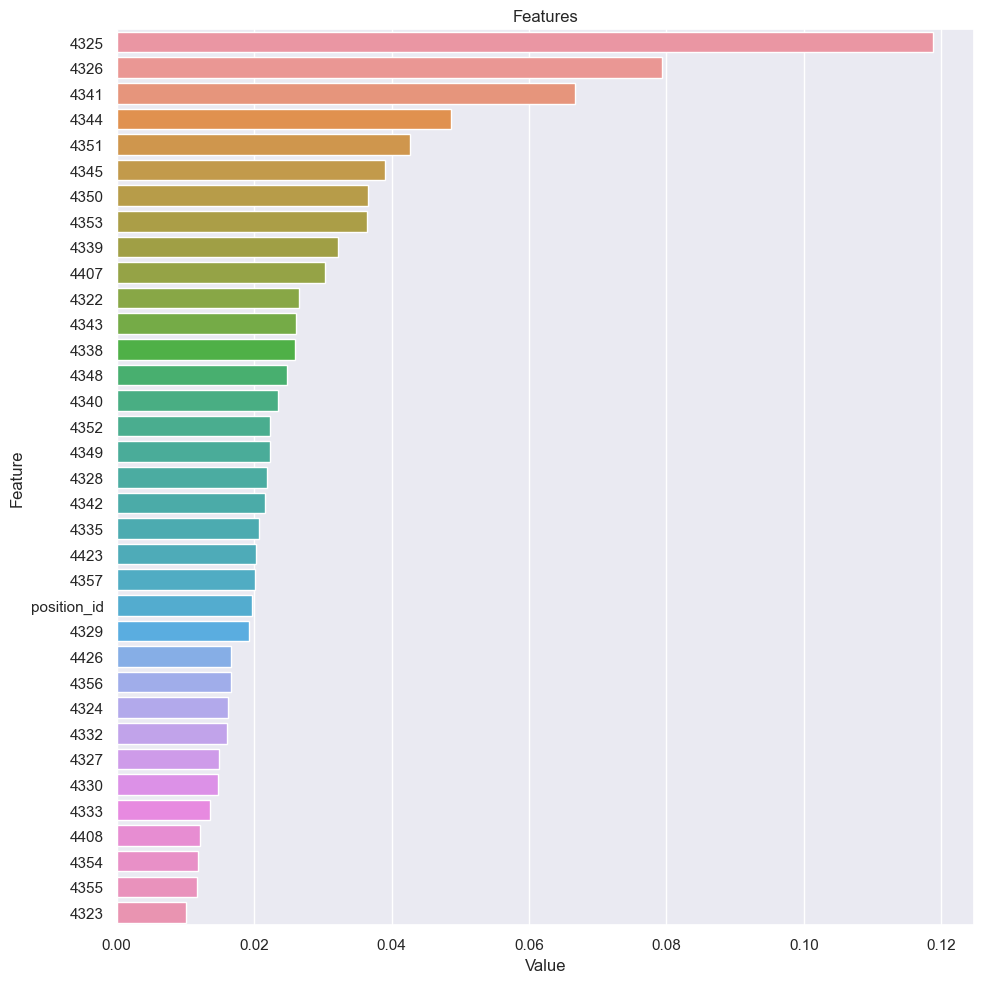

Feature Importance for LightGBM:
    Value      Feature
0     367  position_id
4     255         4325
34    214         4426
19    142         4344
26    139         4353
18    138         4343
13    133         4338
5     132         4326
22    132         4349
10    123         4332
16    111         4341
31    111         4407
23    110         4350
27     89         4354
11     84         4333
3      81         4324
7      77         4328
12     74         4335
20     69         4345
8      68         4329
29     65         4356
1      57         4322
2      42         4323
33     41         4423
15     40         4340
14     39         4339
21     36         4348
28     33         4355
30     30         4357
24     25         4351
32     17         4408
17     15         4342
25      7         4352
9       6         4330
6       2         4327


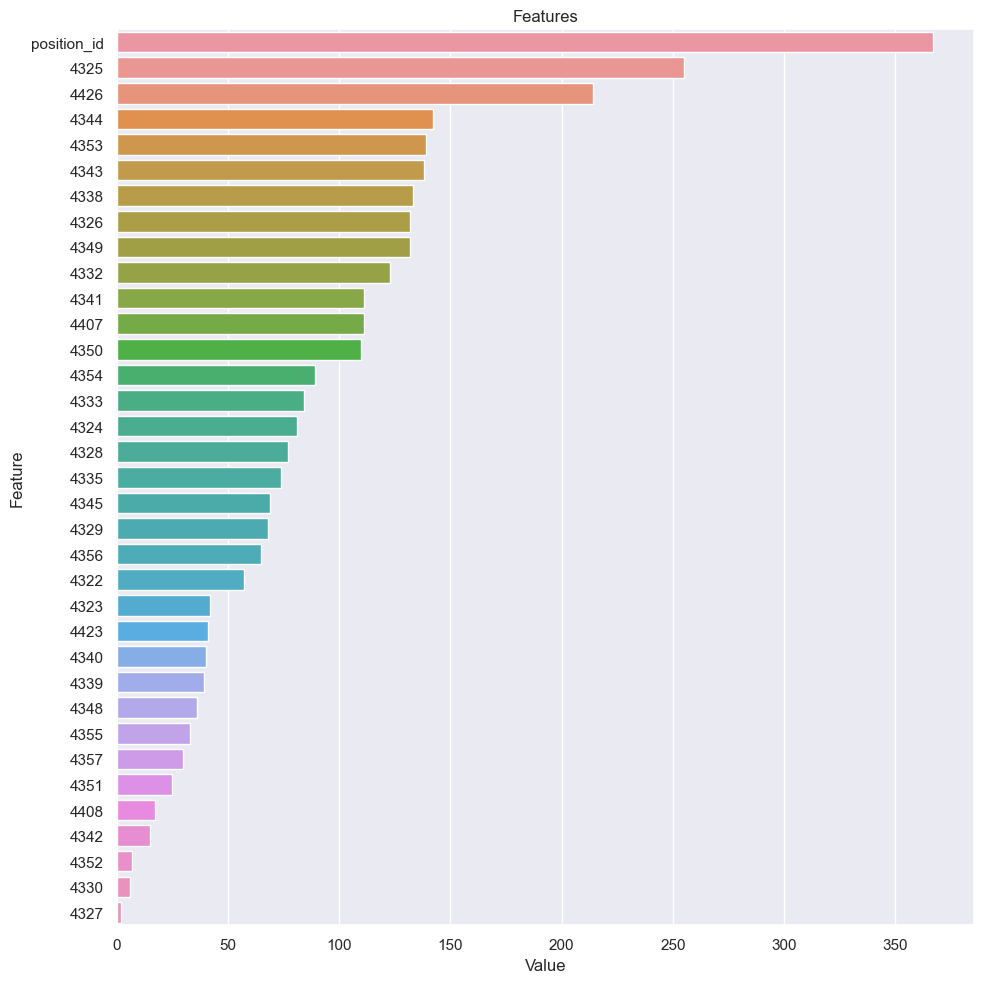

In [38]:
models = [('Random Forest', rf_tuned), ('LightGBM', lgbm_tuned)]

for model_name, model in models:
    print(f'Feature Importance for {model_name}:')
    plot_importance(model, X)